#**Problem Formulation**

**define the problem**
* It is a binary classification problem based on the graph data.

* The task is to predict the anticancer activity of a chemical compound using the chemical structure of the compound.

* The chemical compound can be positive or negative against lung cancer cell and thus labelled as either 0 or 1.

**Define the input data**

* Nodes : Each one contains atoms of the chemical compound in the tokenized form.

* Edges : The relation between each node and others.

* Node2graph : The input tensor which is used for segmented mean and contains information about segmented ids.

**Define the output data**

* The probability is compound-related if the compound is positive or otherwise negative for non-small cell lung cancer. 

**What data mining function is required?**

Data split.

Data plot and visualization.

Data Tokenizer.

Data Padding.

Reshape.

Data resample.

Data Concat.

Embedding and Dense layers.

**What could be the challenges?**

* Since the data contains characters, it must be tokenized and padded.

* The data are also imbalanced and the positive class is too small. 
* This data must be resampled for a good fit. 

**What is the impact?**

Predict anticancer activity and whether a compound is positive for non-small cell lung cancer. 

**What is an ideal solution?**

*(Trial 8 With Balanced Data)*

using "message_calculation_class" ='GNN_FiLM'

#**Questions**

**Based on the provided template, describe the format of the input file (sdf file).**

SDF stands for Structural Data File. The input file contains information about compounds. SDF files store information about the position of individual atoms within a compound and also provide information about the compound.   

**What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?**

* node: The data contains compound nodes in tokenized form.


The shape of each batch is (batch_size*max_len_nodes), where batch_size is the number of samples in the batch and max_len_nodes is the length of tokenized nodes with padding.

* edge: edge is the input tensor which contains the relation between atoms.

The shape of each batch is (sum_of_all_edges,2). The sum_of_all_edges represents the sum edges of each sample of the batch_size.

* node2graph: It is the input tensor which is used for segmented mean and contains information about segmented ids.

The shape of each batch is (batch_size*max_len_nodes).

**For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?**

gnn_out: It represents the aggregate output of the model for each hidden layer.  

avg: This is a method of collecting information for each sample and presenting it in the form of average data. 

**What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?**

**segment_mean** takes the mean of the data which have same segmented ids.

**reduce_mean** computes the mean of elements across dimensions of a tensor given the arguments.

pred The final output shape is a number which represents the probability associated with each chemical compound about its activity.

**What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?**

* The default template implements the default setting of the number of layers in the gcn network.
* The default layer are 4 as given in the documentaion.
* The default message passing method is rgcn (Graph convolution layers).
* Using multiple gcn helps in incorporating all the graph complexity properly and thus creates a better model.

#**Meme**

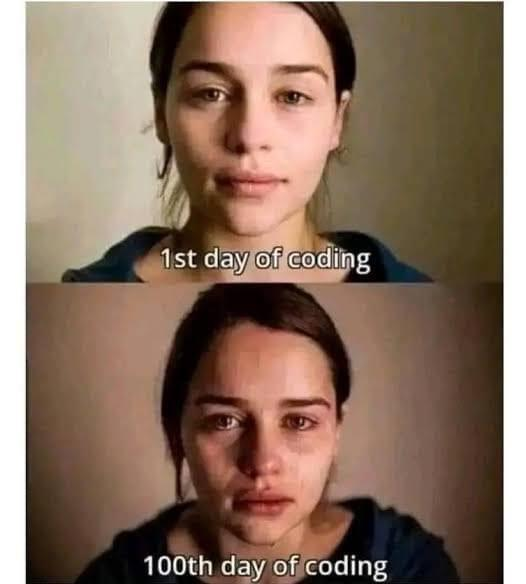

#**installation and importing libraries**


In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --quiet networkx

In [ ]:
!pip install --quiet tf2_gnn

In [ ]:
from tqdm.notebook import tqdm 
import numpy as np
import pandas as pd 
import math
from sklearn.model_selection import train_test_split
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from tensorflow.keras.preprocessing.text import Tokenizer
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tf2_gnn.layers.gnn import GNN, GNNInput
#importing tensorflow and other libraries
import tensorflow as tf
from tensorflow.math import segment_mean #to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model #layers and model
from tensorflow.keras.layers import Embedding, Dense #layers
from tensorflow.keras.optimizers import Adam #optimizer
#importing GGNN,RGCN,RGAT,RGIN,GNN-Edge-MLP,GNN-FiLM
from  tf2_gnn.layers.message_passing import rgat,rgin,rgcn,gnn_film,ggnn,gnn_edge_mlp

#**Read SDF format data (structured-data format)**


In [ ]:
# fun. to read sdf file, the chemical composition of a molecule is saved as (structure data file)
def read_sdf(file):
    with open(file, 'r') as rf:   #opening the file
        content = rf.read()       #reading the contents of the file
    # Split the read file by delimiter $$$$ thus splitting each molecule in an array
    samples = content.split('$$$$') 
    
    #fun. to read each molecule configuration
    def parse_sample(s):
        lines = s.splitlines()    #splitting the text data to lines
        links = []                #empty array for links
        nodes = []                #empty array for nodes
        label = 0
        #loop over each line
        for l in lines:           
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            # for Atom block 
            if l.startswith('    '):   
                feature = l.split()
                #node feature (atom) as O,C etc.
                node = feature[3] 
                #appending nodes    
                nodes.append(node) 
            # bond block tells about connections between atoms   
            elif l.startswith(' '):   
                # splitting line
                lnk = l.split()       
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    #appending links
                    links.append((int(lnk[0])-1, int(lnk[1])-1,))
        return nodes, np.array(links), label #return nodes, links and label
    # parse_sample for each molecule
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]

In [ ]:
#load the training data
training_set = read_sdf("/content/train.sdf")
#load the testing data
testing_set = read_sdf('/content/test_x.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

In [ ]:
#splitting the train data into training set and validation set by 85 to 15 
training_set, validation_set = train_test_split(training_set, test_size=0.15,)

In [ ]:
#print index 1 in the training set
print(training_set[1])

(['O', 'O', 'O', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0,  4],
       [ 0,  6],
       [ 1,  3],
       [ 2,  3],
       [ 3,  5],
       [ 4,  5],
       [ 4,  8],
       [ 5,  9],
       [ 6,  7],
       [ 6, 10],
       [ 7,  9],
       [ 7, 11],
       [ 8, 12],
       [ 8, 13],
       [10, 14],
       [11, 15],
       [12, 16],
       [13, 17],
       [14, 15],
       [16, 18],
       [17, 18]]), 0)


#**Visualizing/Inspecting a Sample**

Data are included in the training set for each sample (molecule). Three elements are present in each sample array. The first element gives textual information about atoms, the second element gives textual information about compounds, and the third element gives textual information about the labels of each molecule. 


In [ ]:
#importing libraries for displaying network of molecule
colors = cm.rainbow(np.linspace(0, 1, 50))

In [ ]:
#method to visualize the compound graph
#atoms are given as nodes
#the connections are defined as edges
def visualize(sample):
#initiating an instance of Graph
    Gr=nx.Graph() 
#atoms as nodes
    nodes = sample[0] 
#connections as edges
    edges = sample[1] 
#empty dictionary for labels for the nodes
    labeldict={} 
#empty array for each node color
    node_color=[] 
#for each node in the sample
    for i,n in enumerate(nodes): 
#adding node to the graph each node as (0,1,2,3..)
        Gr.add_node(i)   
#dictionary building with [key,value] as [0:'C']
        labeldict[i]=n  
#print(i)
#print(n)
#color coding
        node_color.append(colors[hash(n)%len(colors)]) 

# a list of nodes:
#for each edge
    for e in edges:
#adding egde to the graph from one connection to other connection
        Gr.add_edge(e[0], e[1]) 
#drawing the graph with labels for nodes as atoms and connections as edges    
    nx.draw(Gr, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
#returns graph
    return Gr
     

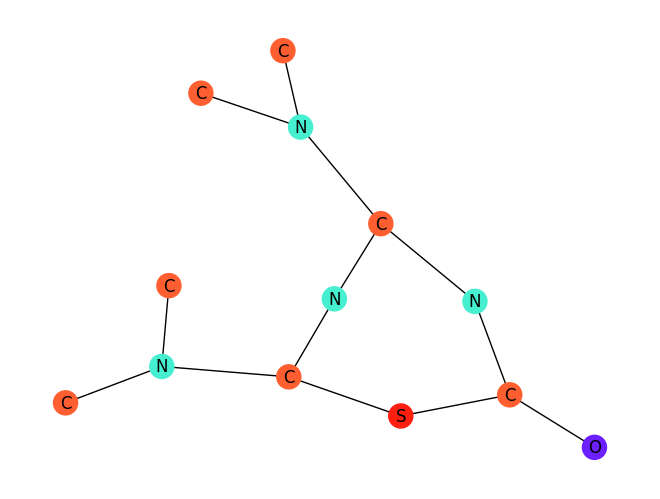

In [ ]:
#displaying one sample
plt.clf()
visualize(training_set[0])

#**Preprocessing**

In [ ]:
max_vocab = 500
max_len = 100
# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [ ]:
random.seed(10)

#method to prepare single batch set
#samples represents the batch of data
def prepare_single_batch(samples):
 #nodes characters array
    sample_nodes = [s[0] for s in samples]  
#tokenizing the sample nodes                   
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)   
#pad_sequences for each sample node with post padding
    sample_nodes = pad_sequences(sample_nodes, padding='post')  
#maximum length of nodes 
    max_nodes_len = np.shape(sample_nodes)[1]                   
#defining edges
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] 
    edges = [e for e in edges if len(e) > 0]
#array definition for segmented_ids
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]  
#reshaping as 1 vector
    all_nodes = np.reshape(sample_nodes, -1)  
#concatenating all the edges as size [total_edges ,2]
    all_edges = np.concatenate(edges)         

    node_to_graph = np.reshape(node_to_graph, -1)
#returns a dictionary of features(data,edges,node2grah) and label
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples]) 

#generating batch with given btch_size
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
 #infinity loop
    while True:                
#data in the array
        dataset = list(dataset) 
# if shuffle is True
        if shuffle:             
#randomly shuffling
            random.shuffle(dataset) 
#length of dataset
        l = len(dataset)  
#loop for  creating batches from given dataset
        for ndx in range(0, l, batch_size):  
#creating batch samples with given batch_size
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] 
#returning a generator with prepared batches
            yield prepare_single_batch(batch_samples)  
#breaking loop if repeat is false 
        if not repeat:  
            break


In [ ]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[2 2 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 2 2 2 3 3
 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 4 4 2 2 2 2 3 3 3 3 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 4 2 2 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0]
edges
[[  0  15]
 [  1  25]
 [  1  29]
 [  2   7]
 [  2   8]
 [  2   9]
 [  3   8]
 [  3  11]
 [  4   8]
 [  4  12]
 [  5  11]
 [  5  20]
 [  5  21]
 [  6  26]
 [  6  27]
 [  6  28]
 [  7  10]
 [  7  13]
 [  9  12]
 [  9  14]
 [ 10  11]
 [ 10  15]
 [ 12  16]
 [ 13  17]
 [ 13  18]
 [ 14  19]
 [ 16  22]
 [ 17  23]
 [ 18  24]
 [ 19  22]
 [ 20  26]
 [ 21  27]
 [ 23  25]
 [ 24  25]
 [ 30  39]
 [ 30  40]
 [ 31  45]
 [ 31  46]
 [ 32  41]
 [ 33  44]
 [ 34  48]
 [ 34  54]
 [ 35  40]
 [ 35  41]
 [ 36  37]
 [ 36  40]
 [ 37  45]
 [ 38  45]
 [ 38  47]
 [ 39  41]
 [ 39  43]
 [ 42  43]
 [ 42  44]
 [ 42  49]
 [ 44  48]
 [ 46  47]
 [ 46  52]
 [ 47  53]
 [ 48  50]
 [ 49  51]
 [ 50  51]
 [ 60  72]
 [ 60  73]
 [ 61  78]
 [ 62  71]
 [ 63  76]
 [ 64  75]
 [ 65  

#**Trial 1**

in this trial didn't change in the template so the accurracy between 70 and 80 % so will change the hyperparameaters in the next trials and recheck the performance.

*the accuracy on kaggle : 78.9%*

In [ ]:
#Input layer for nodes (tokenized text data) 
data = keras.Input(batch_shape=(None,))             

# the first dimension is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data         
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)  
#Input layer for node2graph ids    
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
#embedding layer over data with each token embedded as  size vector 
embeded = Embedding(tokenizer.num_words, 100)(data)  
# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))    
num_graph = tf.reduce_max(node2graph)+1  
#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
#sets the size of the output of all message passing layers.
params["hidden_dim"] = 40  
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  
#gnn output layer 
#outpur shape: [data_dimension,hidden layers]   
gnn_out = gnn_layer(gnn_input) 
print('gnn_out', gnn_out)           
#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    ) #shape: [batch_size,64]  

print('mean:', avg)

#final dense layer with sigmoid
#output shape: [batch_size,1]
pred = Dense(1, activation='sigmoid')(avg)  
print('pred:', pred)

#building model 
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#printing summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

**Compile The Model**


In [ ]:
#compile the model by usnig adam as optimizer and using binarycrossentropy for calculate the loss and check the acc by AUC 
model.compile( optimizer='adam',loss='BinaryCrossentropy',metrics=['AUC'])

**Train The Model**


In [ ]:
batch_size = 8
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
#train our model 
model.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
          steps_per_epoch=num_batchs,epochs=20,validation_data=gen_batch(validation_set, batch_size=16, repeat=True),
          validation_steps=num_batchs_validation)

Epoch 1/20
2659/2659 [==============================] - 36s 14ms/step - loss: 0.1999 - auc: 0.5694 - val_loss: 0.2124 - val_auc: 0.6441
Epoch 2/20
2659/2659 [==============================] - 43s 16ms/step - loss: 0.1851 - auc: 0.6673 - val_loss: 0.1999 - val_auc: 0.6997
Epoch 3/20
2659/2659 [==============================] - 38s 14ms/step - loss: 0.1815 - auc: 0.6900 - val_loss: 0.1899 - val_auc: 0.7225
Epoch 4/20
2659/2659 [==============================] - 42s 16ms/step - loss: 0.1775 - auc: 0.7152 - val_loss: 0.1905 - val_auc: 0.7222
Epoch 5/20
2659/2659 [==============================] - 50s 19ms/step - loss: 0.1735 - auc: 0.7411 - val_loss: 0.2036 - val_auc: 0.7508
Epoch 6/20
2659/2659 [==============================] - 41s 15ms/step - loss: 0.1716 - auc: 0.7526 - val_loss: 0.1810 - val_auc: 0.7656
Epoch 7/20
2659/2659 [==============================] - 39s 15ms/step - loss: 0.1698 - auc: 0.7572 - val_loss: 0.1827 - val_auc: 0.7610
Epoch 8/20
2659/2659 [==========================

**Predictoin And Submission**


In [ ]:
#make prediction on test data by using the trained model 
y_pred = model.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 7s 9ms/step


In [ ]:
len(y_pred)

12326

In [ ]:
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('submission_trial_1.csv')

#**Trial 2**
in this trial change the "message_calculation_class" = 'GGNN' Compute new graph states by neural message passing and gated units on the nodes. but by using unbalanced data.

while checking the accurracy it is between 63 to 74 % it's not that good  so check another hyperparameaters.

*the accuracy on kaggle : 74.9%*

**Model Structure**


In [ ]:
#Input layer for nodes (tokenized text data)          
data = keras.Input(batch_shape=(None,)) 
# the first dimension is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data        
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)   
#Input layer for node2graph ids    
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
#embedding layer over data with each token embedded as  size vector
embeded = Embedding(tokenizer.num_words, 75)(data)  
# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))  
num_graph = tf.reduce_max(node2graph)+1  
#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 32 
params["message_calculation_class"] = 'GGNN'
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
#outpur shape: [data_dimension,hidden layers]  
gnn_out = gnn_layer(gnn_input) 
print('gnn_out', gnn_out)           
#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )#shape: [batch_size,64] 

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(8,activation='relu')(avg) 
#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc1)   
print('pred:', pred)

#building model 
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model_2 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#printing summary of the model
model_2.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []        

**Compile The Model**

In [ ]:
model_2.compile( loss='BinaryCrossentropy', metrics=['AUC'])

**Train The Model**


In [ ]:
batch_size = 64
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size) 
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) 

model_2.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,epochs=20,
    validation_data=gen_batch(validation_set, batch_size=16, repeat=True),
    validation_steps=num_batchs_validation)

Epoch 1/20
333/333 [==============================] - 32s 86ms/step - loss: 0.2311 - auc: 0.5531 - val_loss: 0.2360 - val_auc: 0.5074
Epoch 2/20
333/333 [==============================] - 28s 84ms/step - loss: 0.1850 - auc: 0.6382 - val_loss: 0.1910 - val_auc: 0.6449
Epoch 3/20
333/333 [==============================] - 30s 89ms/step - loss: 0.1840 - auc: 0.6473 - val_loss: 0.2089 - val_auc: 0.6303
Epoch 4/20
333/333 [==============================] - 32s 97ms/step - loss: 0.1817 - auc: 0.6637 - val_loss: 0.1773 - val_auc: 0.7125
Epoch 5/20
333/333 [==============================] - 37s 112ms/step - loss: 0.1814 - auc: 0.6609 - val_loss: 0.2017 - val_auc: 0.6103
Epoch 6/20
333/333 [==============================] - 28s 86ms/step - loss: 0.1809 - auc: 0.6668 - val_loss: 0.2104 - val_auc: 0.6012
Epoch 7/20
333/333 [==============================] - 28s 85ms/step - loss: 0.1799 - auc: 0.6695 - val_loss: 0.2036 - val_auc: 0.6870
Epoch 8/20
333/333 [==============================] - 28s 85m

**Predictoin And Submission**


In [ ]:
#make prediction on test data by using the trained model 
y_pred_2 = model_2.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred_2 = np.reshape(y_pred_2, -1)

771/771 [==============================] - 8s 10ms/step


In [ ]:
len(y_pred_2)

12326

In [ ]:
submission = pd.DataFrame({'label':y_pred_2})
submission.index.name = 'id'
submission.to_csv('submission_trial_2.csv')

#**Trial 3**
in this trial add hyperparameters num_edge_MLP_hidden_layers by 16 and use message_calculation_class" = 'RGCN' and another change in the number of a vector space of 50 dimensions in which words will be embedded and in hidden_dim by 64


while checking the accurracy it is between 57 to 61 % it's not that good  so check another hyperparameaters.

*the accuracy on kaggle : 63.6%*

**Model Structure**

In [ ]:
#Input layer for nodes (tokenized text data)          
data = keras.Input(batch_shape=(None,)) 
# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data        
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)   
#Input layer for node2graph ids    
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
#embedding layer over data with each token embedded as  size vector
embeded = Embedding(tokenizer.num_words, 50)(data)  

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))  
num_graph = tf.reduce_max(node2graph)+1  
#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 64
#Relational Graph Convolutional Networks  
params["message_calculation_class"] = 'RGCN'
params["num_edge_MLP_hidden_layers"] = 16
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
#outpur shape: [data_dimension,hidden layers]  
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )#shape: [batch_size,64] 

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(8,activation='relu')(avg) 
#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc1)   
print('pred:', pred)

#building model 
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model_3 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#printing summary of the model
model_3.summary()
     

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []        

**Compile The Model**

In [ ]:
model_3.compile( loss='BinaryCrossentropy', metrics=['AUC'])

**Train The Model**


In [ ]:
batch_size = 32

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size) 
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) 

model_3.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(validation_set, batch_size=16, repeat=True),
    validation_steps=num_batchs_validation)

Epoch 1/20
665/665 [==============================] - 81s 109ms/step - loss: 0.3073 - auc: 0.4264 - val_loss: 0.2244 - val_auc: 0.3866
Epoch 2/20
665/665 [==============================] - 71s 106ms/step - loss: 0.2021 - auc: 0.4371 - val_loss: 0.2168 - val_auc: 0.6283
Epoch 3/20
665/665 [==============================] - 74s 112ms/step - loss: 0.1919 - auc: 0.5765 - val_loss: 0.1798 - val_auc: 0.6246
Epoch 4/20
665/665 [==============================] - 72s 108ms/step - loss: 0.1916 - auc: 0.6044 - val_loss: 0.2397 - val_auc: 0.6085
Epoch 5/20
665/665 [==============================] - 72s 108ms/step - loss: 0.1902 - auc: 0.6109 - val_loss: 0.2090 - val_auc: 0.5772
Epoch 6/20
665/665 [==============================] - 71s 106ms/step - loss: 0.1912 - auc: 0.5968 - val_loss: 0.1998 - val_auc: 0.6428
Epoch 7/20
665/665 [==============================] - 72s 108ms/step - loss: 0.1895 - auc: 0.6158 - val_loss: 0.2046 - val_auc: 0.5914
Epoch 8/20
665/665 [==============================] - 7

**Predictoin And Submission**



In [ ]:
#make prediction on test data by using the trained model 
y_pred_3 = model_3.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred_3 = np.reshape(y_pred_3, -1)

771/771 [==============================] - 15s 18ms/step


In [ ]:
len(y_pred_3)

12326

In [ ]:
submission = pd.DataFrame({'label':y_pred_3})
submission.index.name = 'id'
submission.to_csv('submission_trial_3.csv')

#**Trial 4**
in this trial use "message_calculation_class"= "RGAT" and hidden_dim by 32 and num_heads by 32 

while checking the accurracy it is between 60 to 70 % it's not that good  so check another hyperparameaters.

*the accuracy on kaggle :68.7%*

**Model Structure**

In [ ]:
# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 60)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
) 
# This chooses the tf2_gnn.layers.message_passing.* layer used in each step.
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32 
#use GGNN as a calculation class 
params["message_calculation_class"]= "RGAT" 
params["num_heads"]=32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)
# create model 
model_4 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_4.summary() 

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_4/SegmentMean:0', description="created by layer 'tf.math.segment_mean_4'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_6/Sigmoid:0', description="created by layer 'dense_6'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []        

**Compile The Model**


In [ ]:
model_4.compile( loss='BinaryCrossentropy', metrics=['AUC'])

**Train The Model**


In [ ]:


batch_size = 400
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model_4.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(validation_set, batch_size=400, repeat=True),
    validation_steps=num_batchs_validation)

Epoch 1/20
54/54 [==============================] - 55s 995ms/step - loss: 0.3302 - auc: 0.3958 - val_loss: 0.2733 - val_auc: 0.3851
Epoch 2/20
54/54 [==============================] - 51s 945ms/step - loss: 0.2738 - auc: 0.3659 - val_loss: 0.2592 - val_auc: 0.3639
Epoch 3/20
54/54 [==============================] - 53s 973ms/step - loss: 0.2435 - auc: 0.3684 - val_loss: 0.2270 - val_auc: 0.4397
Epoch 4/20
54/54 [==============================] - 53s 979ms/step - loss: 0.2124 - auc: 0.4812 - val_loss: 0.2309 - val_auc: 0.4606
Epoch 5/20
54/54 [==============================] - 52s 977ms/step - loss: 0.2025 - auc: 0.5386 - val_loss: 0.2124 - val_auc: 0.6017
Epoch 6/20
54/54 [==============================] - 53s 986ms/step - loss: 0.1969 - auc: 0.5700 - val_loss: 0.2086 - val_auc: 0.6270
Epoch 7/20
54/54 [==============================] - 52s 955ms/step - loss: 0.1974 - auc: 0.5735 - val_loss: 0.2093 - val_auc: 0.5722
Epoch 8/20
54/54 [==============================] - 52s 952ms/step - 

**Predictoin And Submission**


In [ ]:
#make prediction on test data by using the trained model 
y_pred_4 = model_4.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred_4 = np.reshape(y_pred_4, -1)

771/771 [==============================] - 15s 17ms/step


In [ ]:
len(y_pred_4)

12326

In [ ]:
submission = pd.DataFrame({'label':y_pred_4})
submission.index.name = 'id'
submission.to_csv('submission_trial_4.csv')

#**Trial 5**
in this trial change in "message_calculation_class"] = 'RGIN' and change in another hyperparameaters after check the accurracy it's between 70 and 77 % so will check another hyperparameaters.

*the accuracy on kaggle : 77.0%*

**Model Structure**


In [ ]:
#Input layer for nodes (tokenized text data)          
data = keras.Input(batch_shape=(None,)) 
# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data        
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)   
#Input layer for node2graph ids    
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
#embedding layer over data with each token embedded as  size vector
embeded = Embedding(tokenizer.num_words, 150)(data)  

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))  
num_graph = tf.reduce_max(node2graph)+1  
#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 64
#Relational Graph Isomorphism Networks 
params["message_calculation_class"] = 'RGIN'
# params["num_edge_MLP_hidden_layers"] = 32 ##
params["num_aggr_MLP_hidden_layers"] = 6
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
#outpur shape: [data_dimension,hidden layers]  
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )#shape: [batch_size,64] 

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(8,activation='relu')(avg) 
#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc1)   
print('pred:', pred)

#building model 
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model_5 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#printing summary of the model
model_5.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_9/StatefulPartitionedCall:0', description="created by layer 'gnn_9'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None,)]            0           []        

**Compile The Model**


In [ ]:
model_5.compile( loss='BinaryCrossentropy', metrics=['AUC'])

**Train The Model**


In [ ]:
batch_size = 16

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size) 
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) 

model_5.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(validation_set, batch_size=16, repeat=True),
    validation_steps=num_batchs_validation)
    

Epoch 1/20
2529/2529 [==============================] - 158s 61ms/step - loss: 0.6505 - auc: 0.6683 - val_loss: 0.5254 - val_auc: 0.6633
Epoch 2/20
2529/2529 [==============================] - 157s 62ms/step - loss: 0.6132 - auc: 0.7245 - val_loss: 0.6888 - val_auc: 0.6674
Epoch 3/20
2529/2529 [==============================] - 163s 65ms/step - loss: 0.6104 - auc: 0.7283 - val_loss: 0.6862 - val_auc: 0.6804
Epoch 4/20
2529/2529 [==============================] - 159s 63ms/step - loss: 0.6120 - auc: 0.7279 - val_loss: 0.6303 - val_auc: 0.7116
Epoch 5/20
2529/2529 [==============================] - 162s 64ms/step - loss: 0.6105 - auc: 0.7273 - val_loss: 0.7488 - val_auc: 0.7117
Epoch 6/20
2529/2529 [==============================] - 167s 66ms/step - loss: 0.6063 - auc: 0.7363 - val_loss: 0.6970 - val_auc: 0.6894
Epoch 7/20
2529/2529 [==============================] - 167s 66ms/step - loss: 0.5972 - auc: 0.7466 - val_loss: 0.5665 - val_auc: 0.7201
Epoch 8/20
2529/2529 [===================

**Predictoin And Submission**


In [ ]:
#make prediction on test data by using the trained model 
y_pred_5 = model_5.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred_5 = np.reshape(y_pred_5, -1)
     

771/771 [==============================] - 14s 18ms/step


In [ ]:
len(y_pred_5)

12326

In [ ]:
submission = pd.DataFrame({'label':y_pred_5})
submission.index.name = 'id'
submission.to_csv('submission_trial_5.csv')

#***Solve Unbalanced Data***

In [ ]:
from sklearn.utils import resample
#read the training data as a dataframe
df = pd.DataFrame(training_set,columns=['Nodes','Edges','Labels']) 
df_majority = df[df['Labels']==0]  #data with majority class
df_minority = df[df['Labels']==1]  #data with maniority class

print('Shape of Unbalanced Data before Upsampling:')
print(df_majority.shape)
print(df_minority .shape)
print('\n')

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                  # sample with replacement 
                                 replace=True, 
                                 # to match majority class                 
                                 n_samples=len(df_majority),
                                  # reproducible results     
                                 random_state=42)               

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
print('New class counts after Upsampling:')
df_upsampled['Labels'].value_counts()
     

Shape of Unbalanced Data before Upsampling:
(20226, 3)
(1044, 3)


New class counts after Upsampling:


0    20226
1    20226
Name: Labels, dtype: int64

In [ ]:

#convert the dataframe of data to numpy array so we can deal with
training_set= df_upsampled.to_numpy()

#**Trial 6 With Balanced Data**

In this trial use "message_calculation_class": "gnn_edge_mlp" which configures the message passing style

while checking the accurracy it's improved and became between 80 and 95 %

*the accuracy on kaggle : 82.7%*

**Model Structure**


In [ ]:
#identify the 4 GNNInput inputs(data, edge, node2graph, num_graph)
data = keras.Input(batch_shape=(None,))                           #Input layer for nodes (tokenized text data)            
embeded = Embedding(tokenizer.num_words, 100)(data)               #embedding layer over data with each token embedded as  size vector 
# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)         #Input layer for edge data         
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)     #Input layer for node2graph ids    
# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1                           #number of graphs (number of samples) 

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64 
#defining hidden dimension of the gnn layer(the output of all message passing layers)                   
params["message_calculation_class"] = 'gnn_edge_mlp'
params["num_aggr_MLP_hidden_layers"] = 4

#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
gnn_out = gnn_layer(gnn_input) 
print('gnn_out', gnn_out)           


#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )                                     
print('mean:', avg)

#final dense layer with sigmoid activation function
pred = Dense(1, activation='sigmoid')(avg)    
print('pred:', pred)

#building model 
# input : dictionary of data,edges and node2graph
# output: prediction value from dense layer

model_6 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#display model summary 
model_6.summary()
     

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []                  

**Compile The Model**


In [ ]:
model_6.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['AUC'])

**Train The Model**


In [ ]:
batch_size = 16

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size) 
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) 

model_6.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(validation_set, batch_size=16, repeat=True),
    validation_steps=num_batchs_validation)

Epoch 1/20
2530/2530 [==============================] - 95s 36ms/step - loss: 0.6090 - auc: 0.7323 - val_loss: 0.6669 - val_auc: 0.7224
Epoch 2/20
2530/2530 [==============================] - 89s 35ms/step - loss: 0.5733 - auc: 0.7722 - val_loss: 0.5819 - val_auc: 0.7362
Epoch 3/20
2530/2530 [==============================] - 90s 36ms/step - loss: 0.5381 - auc: 0.8068 - val_loss: 0.5461 - val_auc: 0.7547
Epoch 4/20
2530/2530 [==============================] - 88s 35ms/step - loss: 0.5092 - auc: 0.8309 - val_loss: 0.5015 - val_auc: 0.7579
Epoch 5/20
2530/2530 [==============================] - 89s 35ms/step - loss: 0.4880 - auc: 0.8474 - val_loss: 0.5768 - val_auc: 0.7685
Epoch 6/20
2530/2530 [==============================] - 91s 36ms/step - loss: 0.4568 - auc: 0.8681 - val_loss: 0.5171 - val_auc: 0.7895
Epoch 7/20
2530/2530 [==============================] - 91s 36ms/step - loss: 0.4286 - auc: 0.8851 - val_loss: 0.4916 - val_auc: 0.7980
Epoch 8/20
2530/2530 [==========================

**Predictoin And Submission**


In [ ]:

#make prediction on test data by using the trained model 
y_pred_6 = model_6.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred_6 = np.reshape(y_pred_6, -1)

771/771 [==============================] - 9s 11ms/step


In [ ]:
len(y_pred_6)

12326

In [ ]:
submission = pd.DataFrame({'label':y_pred_6})
submission.index.name = 'id'
submission.to_csv('submission_trial_6.csv')

#**Trial 7 With Balanced Data**
in this trial use "message_calculation_class" ='GNN_FiLM' and "film_parameter_MLP_hidden_layers" 

while checking the accurracy it's improved and became between 80 and 97 %

*the accuracy on kaggle :86.8%*


*which is a good model* 

**Model Structure**


In [ ]:
#identify the 4 GNNInput inputs(data, edge, node2graph, num_graph)
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))
#embedding layer over data with each token embedded as  size vector 
#the first dim is different to the previous one. it is the total number of edges in this batch
embeded = Embedding(tokenizer.num_words, 100)(data)              
#Input layer for edge data 
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)         
#Input layer for node2graph ids         
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)        
# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1                           
#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
#defining hidden dimension of the gnn layer(the output of all message passing layers)
params["film_parameter_MLP_hidden_layers"] = 1
params["message_calculation_class"] ='GNN_FiLM'

#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
gnn_out = gnn_layer(gnn_input) 
print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )                                     
print('mean:', avg)

#final dense layer with sigmoid activation function
pred = Dense(1, activation='sigmoid')(avg)    
print('pred:', pred)

#building model 
"""
input : dictionary of data,edges and node2graph
output: prediction value from dense layer
"""
model_7 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#display model summary 
model_7.summary()
     

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []        

**Compile The Model**


In [ ]:
model_7.compile(optimizer='adam',loss='BinaryCrossentropy', metrics=['AUC'])

**Train The Model**


In [ ]:
batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size) 
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) 

model_7.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(validation_set, batch_size=16, repeat=True),
    validation_steps=num_batchs_validation)
     

Epoch 1/20
1265/1265 [==============================] - 115s 83ms/step - loss: 0.5954 - auc: 0.7449 - val_loss: 0.6301 - val_auc: 0.7442
Epoch 2/20
1265/1265 [==============================] - 111s 88ms/step - loss: 0.5211 - auc: 0.8215 - val_loss: 0.6599 - val_auc: 0.8122
Epoch 3/20
1265/1265 [==============================] - 112s 89ms/step - loss: 0.4703 - auc: 0.8590 - val_loss: 0.5532 - val_auc: 0.8047
Epoch 4/20
1265/1265 [==============================] - 106s 84ms/step - loss: 0.4309 - auc: 0.8836 - val_loss: 0.5268 - val_auc: 0.8118
Epoch 5/20
1265/1265 [==============================] - 117s 93ms/step - loss: 0.3912 - auc: 0.9047 - val_loss: 0.4807 - val_auc: 0.7946
Epoch 6/20
1265/1265 [==============================] - 126s 99ms/step - loss: 0.3646 - auc: 0.9181 - val_loss: 0.5670 - val_auc: 0.8288
Epoch 7/20
1265/1265 [==============================] - 112s 88ms/step - loss: 0.3318 - auc: 0.9320 - val_loss: 0.4665 - val_auc: 0.8183
Epoch 8/20
1265/1265 [===================

**Predictoin And Submission**


In [ ]:
#make prediction on test data by using the trained model 
y_pred_7 = model_7.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred_7 = np.reshape(y_pred_7, -1)

771/771 [==============================] - 9s 12ms/step


In [ ]:
len(y_pred_7)

12326

In [ ]:
submission = pd.DataFrame({'label':y_pred_7})
submission.index.name = 'id'
submission.to_csv('submission_trial_7.csv')

#**Trial 8 With Balanced Data**
in this trial use "message_calculation_class" ='GNN_FiLM' but different hyperparameaters and after checking the accurracy it's between 90 and 97%

*the accuracy o kaggle : 88.1%*

*which is the best model*

**Model Structure**


In [ ]:
#identify the 4 GNNInput inputs(data, edge, node2graph, num_graph)
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))  
#embedding layer over data with each token embedded as  size vector                                      
embeded = Embedding(tokenizer.num_words, 100)(data)               
# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data 
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)         
#Input layer for node2graph ids        
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)         
# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1                           

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer(the output of all message passing layers)
params["hidden_dim"] = 40
params["film_parameter_MLP_hidden_layers"] = 1
params["message_calculation_class"] ='GNN_FiLM'

#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
gnn_out = gnn_layer(gnn_input) 
print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )                                     
print('mean:', avg)

#final dense layer with sigmoid activation function
pred = Dense(1, activation='sigmoid')(avg)    
print('pred:', pred)

#building model 
# input : dictionary of data,edges and node2graph
# output: prediction value from dense layer

model_8 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#display model summary 
model_8.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_8/StatefulPartitionedCall:0', description="created by layer 'gnn_8'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None,)]            0           []        

**Compile The Model**


In [ ]:
model_8.compile(optimizer=keras.optimizers.Adam(),loss='BinaryCrossentropy',metrics=['AUC'])

**Train The Model**


In [ ]:
batch_size = 32

#math.ceil: returns the smallest integral value greater than the number
num_batchs            = math.ceil(len(training_set) / batch_size)   #no. of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) #no. of batches for validation data

model_8.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    validation_data=gen_batch(validation_set, batch_size=batch_size, repeat=True),
    validation_steps=num_batchs_validation,
     epochs=20,
)

Epoch 1/20
1265/1265 [==============================] - 80s 58ms/step - loss: 0.5923 - auc: 0.7493 - val_loss: 0.5977 - val_auc: 0.7798
Epoch 2/20
1265/1265 [==============================] - 81s 64ms/step - loss: 0.5063 - auc: 0.8335 - val_loss: 0.5379 - val_auc: 0.7791
Epoch 3/20
1265/1265 [==============================] - 82s 65ms/step - loss: 0.4517 - auc: 0.8711 - val_loss: 0.3806 - val_auc: 0.7967
Epoch 4/20
1265/1265 [==============================] - 81s 64ms/step - loss: 0.4080 - auc: 0.8961 - val_loss: 0.4744 - val_auc: 0.8052
Epoch 5/20
1265/1265 [==============================] - 79s 63ms/step - loss: 0.3721 - auc: 0.9146 - val_loss: 0.5374 - val_auc: 0.8195
Epoch 6/20
1265/1265 [==============================] - 72s 57ms/step - loss: 0.3451 - auc: 0.9258 - val_loss: 0.4415 - val_auc: 0.8234
Epoch 7/20
1265/1265 [==============================] - 83s 65ms/step - loss: 0.3201 - auc: 0.9357 - val_loss: 0.4694 - val_auc: 0.8160
Epoch 8/20
1265/1265 [==========================

**Predictoin And Submission**


In [ ]:
#make prediction on test data by using the trained model 
y_pred_8 = model_8.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred_8 = np.reshape(y_pred_8, -1)

771/771 [==============================] - 8s 10ms/step


In [ ]:
len(y_pred_8)

12326

In [ ]:
submission = pd.DataFrame({'label':y_pred_8})
submission.index.name = 'id'
submission.to_csv('submission_trial_8.csv')

#**Trial 9 With Balanced Data**
in this trial use as the second trial but after balance the data    

the accurracy became between 80 and 95 % but not stable

*the accuracy on kaggle : 84.9%*

**Model Structure**


In [ ]:
#Input layer for nodes (tokenized text data)          
data = keras.Input(batch_shape=(None,)) 
# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data        
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)   
#Input layer for node2graph ids    
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
#embedding layer over data with each token embedded as  size vector
embeded = Embedding(tokenizer.num_words, 75)(data)  

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))  
num_graph = tf.reduce_max(node2graph)+1  
#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 32 
params["message_calculation_class"] = 'GGNN'
#params["num_edge_MLP_hidden_layers"] = 16
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
#outpur shape: [data_dimension,hidden layers]  
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )#shape: [batch_size,64] 

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(8,activation='relu')(avg) 
#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc1)   
print('pred:', pred)

#building model 
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model_9 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#printing summary of the model
model_9.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_10/StatefulPartitionedCall:0', description="created by layer 'gnn_10'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_4/SegmentMean:0', description="created by layer 'tf.math.segment_mean_4'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_6/Sigmoid:0', description="created by layer 'dense_6'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None,)]            0           []      

**Compile The Model**


In [ ]:
model_9.compile(optimizer='adam',loss='BinaryCrossentropy', metrics=['AUC'])


**Train The Model**


In [ ]:
batch_size = 64

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size) 
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) 

model_9.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(validation_set, batch_size=16, repeat=True),
    validation_steps=num_batchs_validation)
     

Epoch 1/20
633/633 [==============================] - 72s 105ms/step - loss: 0.6211 - auc: 0.7048 - val_loss: 0.7995 - val_auc: 0.6492
Epoch 2/20
633/633 [==============================] - 66s 104ms/step - loss: 0.5828 - auc: 0.7547 - val_loss: 0.6372 - val_auc: 0.7379
Epoch 3/20
633/633 [==============================] - 67s 106ms/step - loss: 0.5508 - auc: 0.7919 - val_loss: 0.8384 - val_auc: 0.7529
Epoch 4/20
633/633 [==============================] - 66s 105ms/step - loss: 0.5127 - auc: 0.8265 - val_loss: 0.8003 - val_auc: 0.8160
Epoch 5/20
633/633 [==============================] - 67s 105ms/step - loss: 0.4851 - auc: 0.8477 - val_loss: 0.7800 - val_auc: 0.8230
Epoch 6/20
633/633 [==============================] - 67s 105ms/step - loss: 0.4541 - auc: 0.8686 - val_loss: 0.5494 - val_auc: 0.7656
Epoch 7/20
633/633 [==============================] - 63s 100ms/step - loss: 0.4299 - auc: 0.8832 - val_loss: 0.7223 - val_auc: 0.8216
Epoch 8/20
633/633 [==============================] - 6

**Predictoin And Submission**


In [ ]:
#make prediction on test data by using the trained model 
y_pred_9 = model_9.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred_9 = np.reshape(y_pred_9, -1)

771/771 [==============================] - 9s 10ms/step


In [ ]:
len(y_pred_9)

12326

In [ ]:
submission = pd.DataFrame({'label':y_pred_9})
submission.index.name = 'id'
submission.to_csv('submission_trial_9.csv')

#**Trial 10 With Balanced Data**
in this trial use "message_calculation_class" = 'RGCN' as the same in the third trial with the balanced data   

the accurracy became 77 and 97 and if increase in the number of epochs the performance of the model will increase.

 *the accuracy on kaggle : 79.7%*

**Model Structure**


In [ ]:
#Input layer for nodes (tokenized text data)          
data = keras.Input(batch_shape=(None,)) 
# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data        
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)   
#Input layer for node2graph ids    
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
#embedding layer over data with each token embedded as  size vector
embeded = Embedding(tokenizer.num_words, 50)(data)  

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))  
num_graph = tf.reduce_max(node2graph)+1  
#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 64
#Relational Graph Convolutional Networks  
params["message_calculation_class"] = 'RGCN'
# params["num_edge_MLP_hidden_layers"] = 32
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
#outpur shape: [data_dimension,hidden layers]  
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )#shape: [batch_size,64] 

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(8,activation='LeakyReLU')(avg) 
#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc1)   
print('pred:', pred)

#building model 
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model_10 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#printing summary of the model
model_10.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_11/StatefulPartitionedCall:0', description="created by layer 'gnn_11'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_8/Sigmoid:0', description="created by layer 'dense_8'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None,)]            0           []      

**Compile The Model**


In [ ]:
model_10.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['AUC'])


**Train The Model**


In [ ]:
batch_size = 32

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size) 
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) 

model_10.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(validation_set, batch_size=16, repeat=True),
    validation_steps=num_batchs_validation)

Epoch 1/30
1265/1265 [==============================] - 73s 55ms/step - loss: 0.6074 - auc: 0.7314 - val_loss: 0.9273 - val_auc: 0.6059
Epoch 2/30
1265/1265 [==============================] - 70s 55ms/step - loss: 0.5730 - auc: 0.7708 - val_loss: 0.5676 - val_auc: 0.7866
Epoch 3/30
1265/1265 [==============================] - 72s 57ms/step - loss: 0.5520 - auc: 0.7907 - val_loss: 0.7058 - val_auc: 0.6948
Epoch 4/30
1265/1265 [==============================] - 72s 57ms/step - loss: 0.5314 - auc: 0.8106 - val_loss: 0.6674 - val_auc: 0.7742
Epoch 5/30
1265/1265 [==============================] - 73s 58ms/step - loss: 0.5071 - auc: 0.8310 - val_loss: 0.6894 - val_auc: 0.7502
Epoch 6/30
1265/1265 [==============================] - 70s 55ms/step - loss: 0.4916 - auc: 0.8432 - val_loss: 0.6114 - val_auc: 0.7962
Epoch 7/30
1265/1265 [==============================] - 73s 57ms/step - loss: 0.4679 - auc: 0.8592 - val_loss: 0.5468 - val_auc: 0.7795
Epoch 8/30
1265/1265 [==========================

**Predictoin And Submission**

In [ ]:
#make prediction on test data by using the trained model 
y_pred_10 = model_10.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred_10 = np.reshape(y_pred_10, -1)

771/771 [==============================] - 10s 12ms/step


In [ ]:
len(y_pred_10)

12326

In [ ]:
submission = pd.DataFrame({'label':y_pred_10})
submission.index.name = 'id'
submission.to_csv('submission_trial_10.csv')